In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/fitness.py
%run ../Scripts/coverage.py
%run ../Scripts/initMethods.py

In [4]:
params = { #parameters relevant for the equations
    "Nh":           10000,
    "N0":           10000,
    "R0":              20,
    "M":               10, #Also L, total number of spacers
    "Np":            1000,
    "dc":              10, #Required number of complexes to activate defence
    "h":                4, #coordination coeff
    "r":               10, #cross-reactivity kernel
}

sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    160,
    "dx":                           1,
    "dt":                           1,
    "initial_mean_n":           [0,-80],
    "initial_var_n":               10,
    "initial_mean_nh":          [0,00],
    "initial_var_nh":              10,
    "conv_size":                  320,
    "num_threads":                  4,
}

/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_85447/1392697183.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(n.todense(), label = "n", cmap = "Reds")
/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_85447/1392697183.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(nh.todense(), label = "nh", cmap = "Blues")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


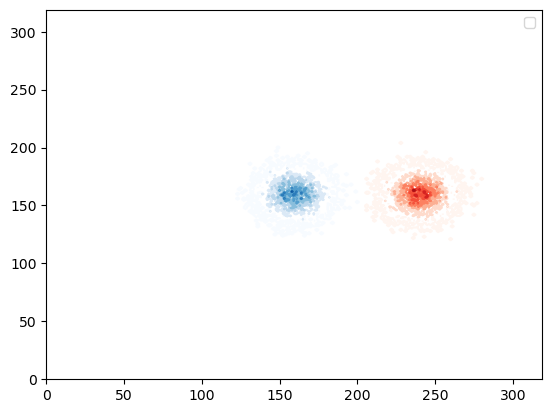

In [4]:
n = init_guassian(params["N0"], sim_params, "n")
nh = init_guassian(params["Nh"], sim_params, "nh")
kernel_quarter = init_quarter_kernel(params, sim_params)
kernel_full = init_full_kernel(params, sim_params)
plt.contour(n.todense(), label = "n", cmap = "Reds")
plt.contour(nh.todense(), label = "nh", cmap = "Blues")
plt.legend()
plt.show()

In [5]:
p_dense = np.arange(0, 1, 0.01)
p_0_spacer = p_zero_spacer(p_dense, params, sim_params)
p_1_spacer = p_single_spacer(p_dense, params, sim_params)

R0 = params["R0"]
fit = np.log(R0*(p_0_spacer + p_1_spacer)) 

Text(0.5, 0, 'Coverage Probability')

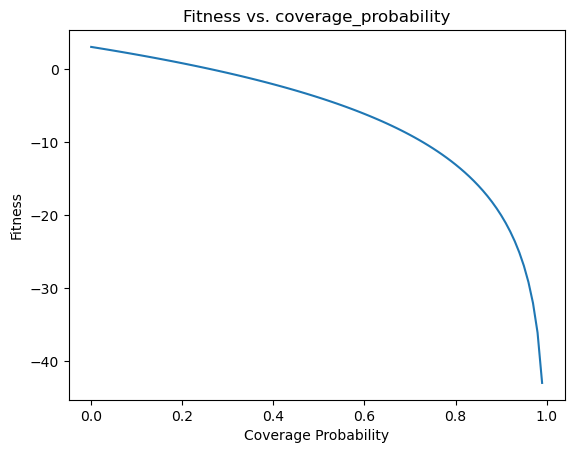

In [6]:
plt.plot(p_dense, fit)
plt.title("Fitness vs. coverage_probability")
plt.ylabel("Fitness")
plt.xlabel("Coverage Probability")

In [7]:
def p_single_spacer2(p_dense, params, sim_params): #TODO Sparsed in Theory
    M = params["M"]
    Np = params["Np"]

    p_1_spacer = binomial_pdf(M, 1, p_dense)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 1/M)*(alpha(d, params))

    p_shared = (1-p_shared)*p_1_spacer
    return p_shared

def p_single_spacer3(p_dense, params, sim_params): #TODO Sparsed in Theory
    M = params["M"]
    Np = params["Np"]

    p_1_spacer = binomial_pdf(M, 1, p_dense)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 1/M)*(1-alpha(d, params))*p_1_spacer

    return p_shared

In [8]:
p_dense = 0.7
list_2_sweep = np.arange(1, 1000, 1)
fit100 = []
fit50 = []
R0 = params["R0"]
params["M"] = 100
p_spacer_list = []

for item in list_2_sweep:
    params["Np"] = item
    p_0_spacer = p_zero_spacer(p_dense, params, sim_params)
    p_1_spacer = p_single_spacer2(p_dense, params, sim_params)

    fit100.append(np.log(R0*(p_0_spacer + p_1_spacer)))

params["M"] = 50

for item in list_2_sweep:
    params["Np"] = item
    p_0_spacer = p_zero_spacer(p_dense, params, sim_params)
    p_1_spacer = p_single_spacer(p_dense, params, sim_params)

    fit50.append(np.log(R0*(p_0_spacer + p_1_spacer)))


In [9]:
Np_range = [0, 10, 100]
M = 10
res_list = []
res2_list = []

def alpha2(x, step):
    if x > step:
        return 1
    else:
        return 0

for Np in Np_range:
    res = 0
    res2 = 0
    for d in range(Np+1):
        # print(d)
        res += binomial_pdf(Np, d, 1/M)*alpha2(d, 5)
        res2 += binomial_pdf(Np, d, 1/M)*(1-alpha2(d, 5))

    res = 1- res
    res_list.append(res)
    res2_list.append(res2)


In [10]:
binomial_pdf(Np, d, 1/M)

1.0000000000000056e-100

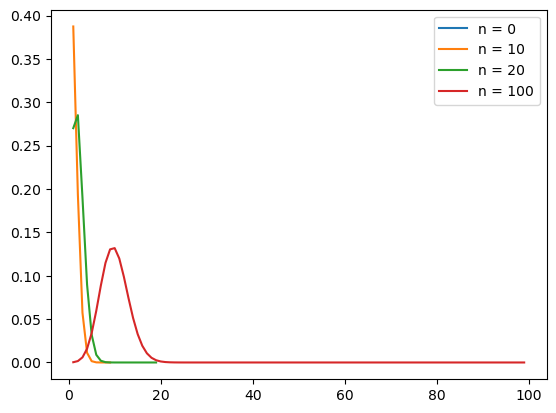

In [13]:
N_list = [0, 10, 20, 100]

for n in N_list:
    x = np.arange(1, n)
    y = binomial_pdf(n, x, 1/10)
    plt.plot(x, y, label = f"n = {n}")
plt.legend()

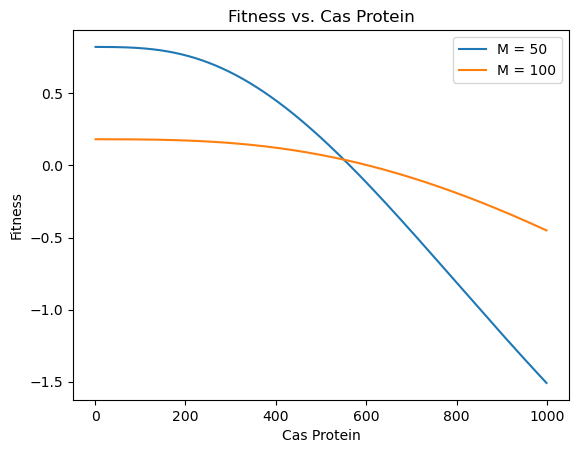

In [14]:
plt.plot(list_2_sweep, fit50 - np.mean(fit50), label = "M = 50")
# plt.plot(list_2_sweep, p_spacer_list, label = "M = 5")
plt.plot(list_2_sweep, fit100 - np.mean(fit100), label = "M = 100")
plt.title("Fitness vs. Cas Protein")
plt.ylabel("Fitness")
plt.xlabel("Cas Protein")
plt.legend()

In [184]:
p_dense = 0.4
list_2_sweep = np.arange(1, 1000, 1)
fit100 = []
fit50 = []
R0 = params["R0"]
params["Np"] = 1000
p_spacer_list = []

for item in list_2_sweep:
    params["M"] = item
    p_0_spacer = p_zero_spacer(p_dense, params, sim_params)
    p_1_spacer = p_single_spacer(p_dense, params, sim_params)

    fit100.append(np.log(R0*(p_0_spacer + p_1_spacer)))

params["Np"] = 100

for item in list_2_sweep:
    params["Np"] = item
    p_0_spacer = p_zero_spacer(p_dense, params, sim_params)
    p_1_spacer = p_single_spacer(p_dense, params, sim_params)

    fit50.append(np.log(R0*(p_0_spacer + p_1_spacer)))


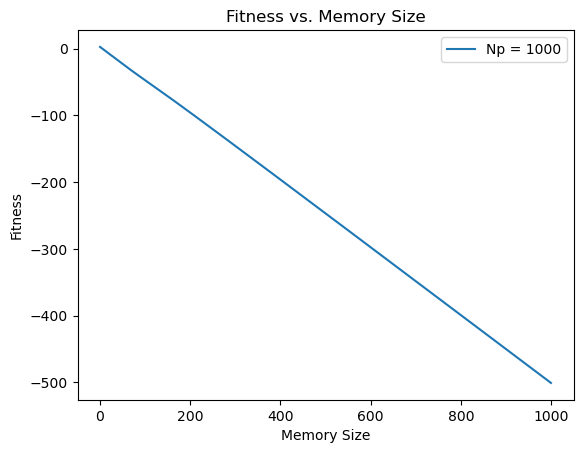

In [188]:
plt.plot(list_2_sweep, fit100, label = "Np = 1000")
# plt.plot(list_2_sweep, p_spacer_list, label = "M = 5")
# plt.plot(list_2_sweep, fit100, label = "Np = 100")
plt.title("Fitness vs. Memory Size")
plt.ylabel("Fitness")
plt.xlabel("Memory Size")
plt.legend()

In [229]:
p_range = np.arange(0, 1, 0.01)
M = 20
R0 = 20
Np = 100
params["dc"] = 10

p_0_spacer_range = (1-p_range)**M

p_1_spacer_range = []

for p in p_range:
    p_1_spacer = binomial_pdf(M, 1, p)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 1/M)*p_1_spacer*(1-alpha(d, params))
    p_1_spacer_range.append(p_shared)

In [230]:
p_range = np.arange(0, 1, 0.01)
M = 1
R0 = 20
Np = 100
params["dc"] = 10

p_0_spacer_range2 = (1-p_range)**M

p_1_spacer_range2 = []

for p in p_range:
    p_1_spacer = binomial_pdf(M, 1, p)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 1/M)*p_1_spacer*(1-alpha(d, params))
    p_1_spacer_range2.append(p_shared)

In [231]:
p_range = np.arange(0, 1, 0.01)
M = 100
R0 = 20
Np = 1000
params["dc"] = 10

p_0_spacer_range3 = (1-p_range)**M

p_1_spacer_range3 = []

for p in p_range:
    p_1_spacer = binomial_pdf(M, 1, p)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 1/M)*p_1_spacer*(1-alpha(d, params))
    p_1_spacer_range3.append(p_shared)

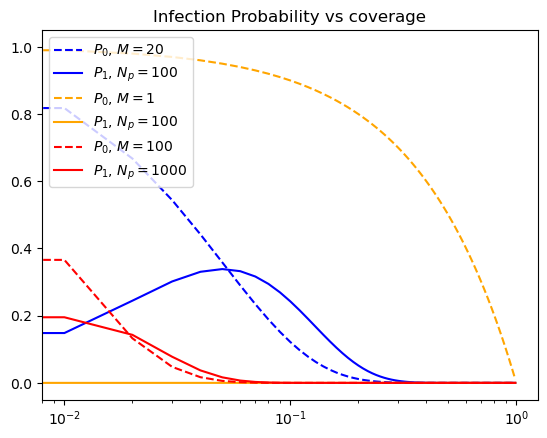

In [232]:
plt.plot(p_range, p_0_spacer_range, label = r"$P_0$, $M = 20$", linestyle = "--", color = "b")
plt.plot(p_range, p_1_spacer_range, label = r"$P_1$, $N_p = 100$", color = "b")
plt.plot(p_range, p_0_spacer_range2, label = r"$P_0$, $M = 1$", linestyle = "--", color = "orange")
plt.plot(p_range, p_1_spacer_range2, label = r"$P_1$, $N_p = 100$", color = "orange")
plt.plot(p_range, p_0_spacer_range3, label = r"$P_0$, $M = 100$", linestyle = "--", color = "red")
plt.plot(p_range, p_1_spacer_range3, label = r"$P_1$, $N_p = 1000$", color = "red")
plt.title("")
plt.xscale("log")
plt.title("Infection Probability vs coverage")
# plt.yscale("log")
plt.legend()

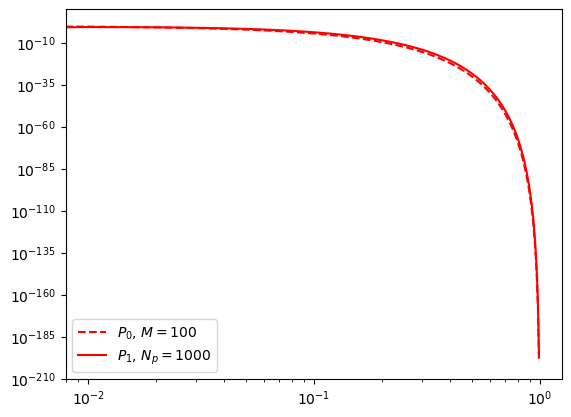

In [77]:
plt.plot(p_range, p_0_spacer_range3, label = r"$P_0$, $M = 100$", linestyle = "--", color = "red")
plt.plot(p_range, p_1_spacer_range3, label = r"$P_1$, $N_p = 1000$", color = "red")
plt.xscale("log")
plt.yscale("log")
plt.title("Probability Distrbution vs Np, M, log scale")
plt.legend()

In [123]:
p_range = np.arange(0, 1, 0.01)
M = 10
R0 = 20
Np = 1000

p_0_spacer_range4 = (1-p_range)**M

p_1_spacer_range4 = []

for p in p_range:
    p_1_spacer = binomial_pdf(M, 1, p)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 1/M)*p_1_spacer*(1-alpha(d, params))
    p_1_spacer_range4.append(p_shared)

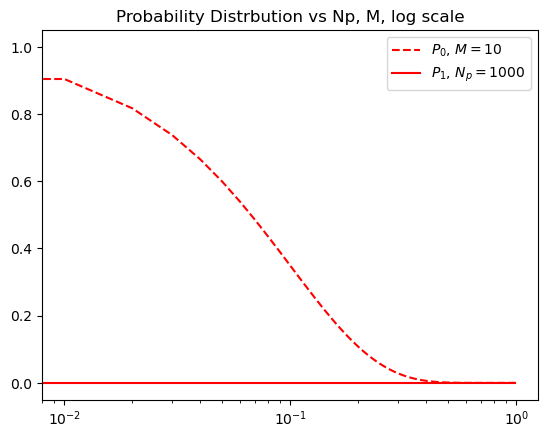

In [124]:
plt.plot(p_range, p_0_spacer_range4, label = rf"$P_0$, $M = {M}$", linestyle = "--", color = "red")
plt.plot(p_range, p_1_spacer_range4, label = rf"$P_1$, $N_p = {Np}$", color = "red")
plt.xscale("log")
# plt.yscale("log")
plt.title("Probability Distrbution vs Np, M, log scale")
plt.legend()

In [2]:
from supMethods import load_last_output, read_json


folder = "../Data_Single_Test_New_Fit"
i, n, nh = load_last_output(folder)
params, sim_params = read_json(folder, results_flag = False)
i

161

In [86]:
kernel_conv = init_quarter_kernel(params, sim_params)

In [89]:
p = elementwise_coverage(nh, n, kernel_conv, params, sim_params)

In [4]:
p = scipy.sparse.load_npz(folder + f"/sp_frame_p{160}.npz").todok()

In [12]:
np.min(nonzero_number)

0.25819290041257553

(array([  4.,  39., 116., 230., 397., 369., 273., 160.,  56.,  11.]),
 array([0.2581929 , 0.26434369, 0.27049449, 0.27664528, 0.28279608,
        0.28894687, 0.29509767, 0.30124846, 0.30739926, 0.31355005,
        0.31970085]),
 <BarContainer object of 10 artists>)

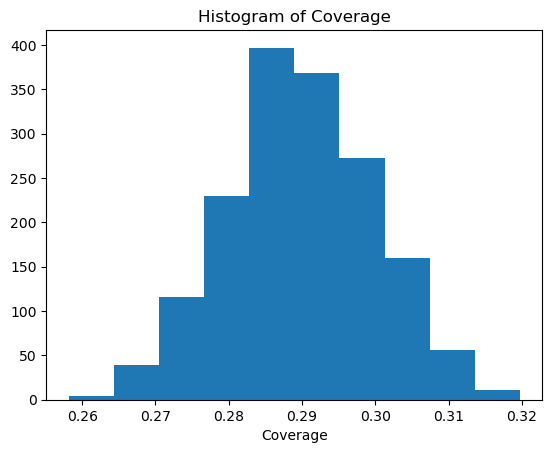

In [5]:
x_ind, y_ind = p.nonzero()
nonzero_number = p[x_ind, y_ind].todense()
plt.title("Histogram of Coverage")
plt.xlabel("Coverage")
plt.hist(np.array(nonzero_number).squeeze())

In [126]:
def front_coverage(x, params):
    M = params["M"]
    Nh = params["Nh"]
    N = params["N"]
    r = params["r"]
    v = params["v0"]
    tau = Nh*M/N

    A = 1/(1+ (v*tau/r))*np.exp(-1*x/r)
    return A

def back_coverage(x, params):
    M = params["M"]
    Nh = params["Nh"]
    N = params["N"]
    r = params["r"]
    v = params["v0"]
    tau = Nh*M/N

    A = r/(r+ (v*tau))
    B = np.exp(-1*x/r) - np.exp(-x/(v*tau))
    return A*B

Text(0.5, 0, '|x|')

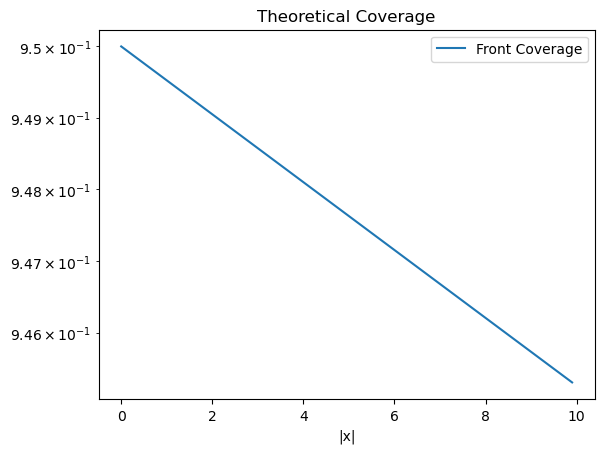

In [195]:
x = np.arange(0, 10, 0.1)
c_front = front_coverage(x, params)
c_back = back_coverage(x, params)

plt.title("Theoretical Coverage")
plt.plot(x, c_front, label = "Front Coverage")
# plt.plot(x, c_back, label = "Back Coverage")
plt.legend()
plt.yscale("log")
plt.xlabel(f"|x|")

Text(0.5, 0, '|x|')

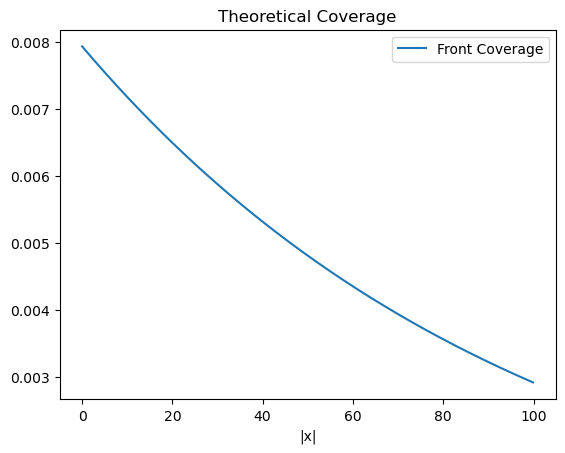

In [239]:
x = np.arange(0, 100, 0.1)
def front_coverage2(x):
    M = 10
    Nh = 1E9
    N = 2E6
    r = 100
    v = 2.5
    tau = Nh*M/N

    A = 1/(1+ (v*tau/r))*np.exp(-1*x/r)
    return A

c_front = front_coverage2(x)
plt.title("Theoretical Coverage")
plt.plot(x, c_front, label = "Front Coverage")
plt.legend()
# plt.yscale("log")
plt.xlabel(f"|x|")

In [197]:
params

{'Nh': 10000000.0,
 'N0': 23755,
 'R0': 20,
 'M': 1,
 'mu': 0.1,
 'gamma_shape': 20,
 'Np': 0,
 'dc': 3,
 'h': 4,
 'r': 2000,
 'beta': 0.0,
 'N': 23755,
 'D': 0.10500000000000001,
 's': 0.0095,
 'tau': 420.96400757735216,
 'v0': 0.2500541190819133,
 'sigma': 5.130446980444177,
 'uc': 15.670942974895157,
 'M0': 1}

In [219]:
D0 = 0.105
D = 100*D0
mu_increase = 1000
v = np.power(mu_increase*D0, 2/3)
print(mu_increase, v)

1000 22.25663649191485


In [17]:
p_range = np.arange(0, 1, 0.01)
M = 20
R0 = 20
Np = 100

p_0_spacer_range0 = (1-p_range)**M

p_1_spacer_range0 = []
for p in p_range:
    p_1_spacer = binomial_pdf(M, 1, p)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 1/M)*p_1_spacer*(1-alpha(d, params))
    p_1_spacer_range0.append(p_shared)

p_2_spacer_range0 = []
for p in p_range:
    p_2_spacer = binomial_pdf(M, 2, p)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 2/M)*p_2_spacer*(1-alpha(d, params))
    p_2_spacer_range0.append(p_shared)

p_3_spacer_range0 = []
for p in p_range:
    p_3_spacer = binomial_pdf(M, 3, p)
    p_shared = 0
    for d in range(0, Np+1):
        p_shared += binomial_pdf(Np, d, 3/M)*p_3_spacer*(1-alpha(d, params))
    p_3_spacer_range0.append(p_shared)

In [7]:
Np

100

In [10]:
params

{'Nh': 10000,
 'N0': 10000,
 'R0': 20,
 'M': 10,
 'Np': 1000,
 'dc': 10,
 'h': 4,
 'r': 10}

In [12]:
Np = 100

d_range = np.arange(0, Np, 1)

q2 = binomial_pdf(Np, d_range, 2/M)
q1 = binomial_pdf(Np, d_range, 1/M)
q3 = binomial_pdf(Np, d_range, 3/M)

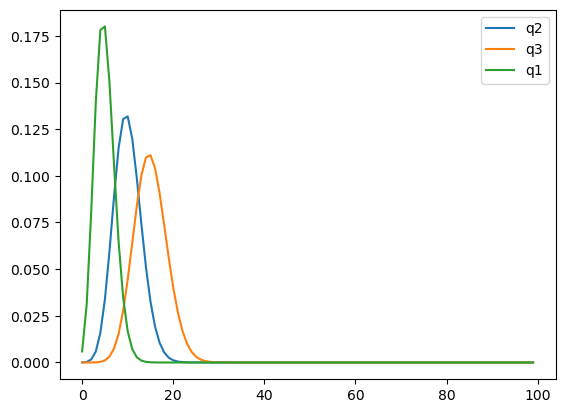

In [16]:
plt.plot(d_range, q2, label = "q2")
plt.plot(d_range, q3, label = "q3")
plt.plot(d_range, q1, label = "q1")
plt.vlines()
plt.legend()

/var/folders/9_/htwk2tpd6tv_fy1sp81nfcsm0000gn/T/ipykernel_45806/4051783764.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1E-7, 0)


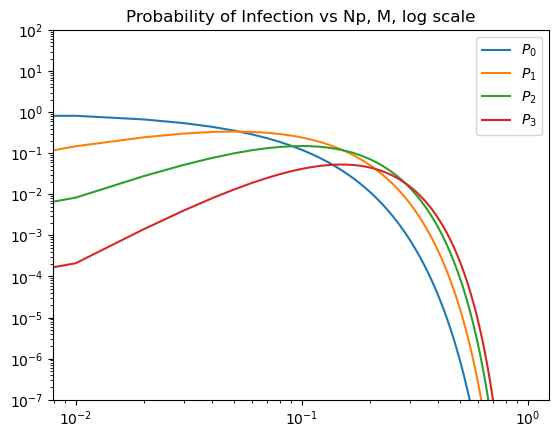

In [21]:
plt.plot(p_range, p_0_spacer_range0, label = r"$P_0$")
plt.plot(p_range, p_1_spacer_range0, label = r"$P_1$")
plt.plot(p_range, p_2_spacer_range0, label = rf"$P_2$")
plt.plot(p_range, p_3_spacer_range0, label = rf"$P_3$")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1E-7, 0)
plt.title("Probability of Infection vs Np, M, log scale")
plt.legend()

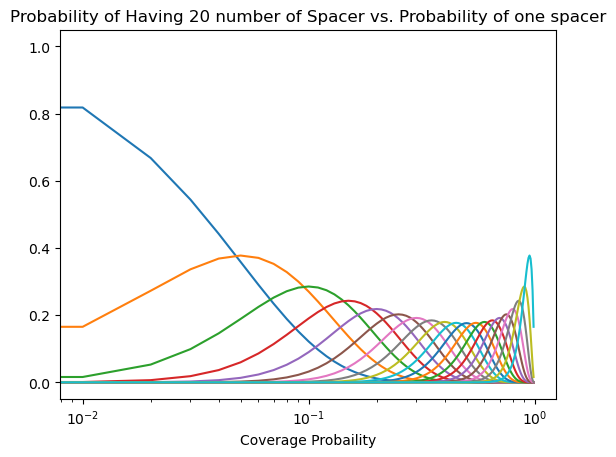

In [240]:
p_range = np.arange(0, 1, 0.01)
M = 20
R0 = 20
Np = 100

n_max = M
num_spacer_list = np.arange(0, n_max)

for i, num_spacer in enumerate(num_spacer_list):
    p_n_spacer_range = []
    for p in p_range:
        p_n_spacer = binomial_pdf(M, num_spacer, p)
        p_n_spacer_range.append(p_n_spacer)
    plt.plot(p_range, p_n_spacer_range)

plt.title(f"Probability of Having {n_max} number of Spacer vs. Probability of one spacer")
plt.xlabel("Coverage Probaility")
plt.xscale("log")